## Second Classifier Prediction Model(s)
The original README file says:
> Often, more than one contact to the same client was required, **in order to access if the product (bank term deposit) would be (or not) subscribed**

This notebook builds off the previous *First Classifier Prediction Model* notebook through additional feature engineering, mainly by dropping additional features which seem unimportant based on extracted feature importances, or which would be unavailable ahead of time in a real business setting.

In [1]:
#import the right libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, log_loss, roc_auc_score, hamming_loss, fbeta_score, auc, roc_curve, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn import metrics
plt.rcParams["figure.figsize"] = (9,9)

In [2]:
#this option just allwos us to see every column in the notebook
pd.set_option('display.max_columns', None)

#pd.get_option("display.max_columns")

In [3]:
#pull in the dataset and turn into a DataFrame
bank_main_df = pd.read_csv('./Dataset_1_Bank Marketing/bank_marketing.csv',delimiter=';')
bank_main_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,NaN,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71.0,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72.0,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57.0,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
bank_main_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,43872.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.924781,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.610835,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
#creating a field that determines whether or not the customer was ever previously contacted
bank_main_df['prior_contact'] = [ 0 if bank_main_df['pdays'][i] == -1 else 1 for i in range(len(bank_main_df))]

#replacing the yes/no categorical values with 1/0 binary digits
bank_main_df['deposit'] = [0 if (bank_main_df['deposit'][i] == 'yes') else 1 for i in range(len(bank_main_df)) ]

#convert the "day" field to a categorical variable
bank_main_df['day'] = pd.Categorical(bank_main_df['day'])

#dropping pdays and previous, because the important information is captured in prior_contact
bank_main_df.drop(columns=['pdays','previous','job','marital','education','default','housing','loan','contact','month','duration'],inplace=True)

In [6]:
#because we have so many cateogrical variables, we should one-hot encode them (i.e. create dummy categorical variables)
#we also use drop_first=True to reduce the redundant column count 
bank_main_df = pd.get_dummies(bank_main_df, drop_first=False)

# bank_main_df

In [7]:
#note that only the "age" category has null values

# pd.isnull(bank_main_df).sum()

# Imputing the missing values in "Age" variable 

* **Iterative Imputer:**
Multivariate imputer that estimates each feature from all the others. A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

In [8]:
# Use multivariate imputer that estimates and imputes null values based on all the others. 

imp = IterativeImputer(max_iter=10, verbose=0) # values passed are defaults, but added them because they seem important... play around
imp.fit(bank_main_df)
imputed_df = imp.transform(bank_main_df)
imputed_df = pd.DataFrame(imputed_df, columns=bank_main_df.columns)

In [9]:
# pd.isnull(imputed_df).sum()

### MinMaxScaler

In [10]:
# StandardScaler, MinMaxScaler, RobustScaler
#scaler = RobustScaler() 
#X_scaled = scaler.fit_transform(imputed_df)

X = imputed_df.drop(columns='deposit')
y = imputed_df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

scaler = MinMaxScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# R-Forest Feature Importance

0.877838395753465


Text(0.5, 0, 'Feature Importance')

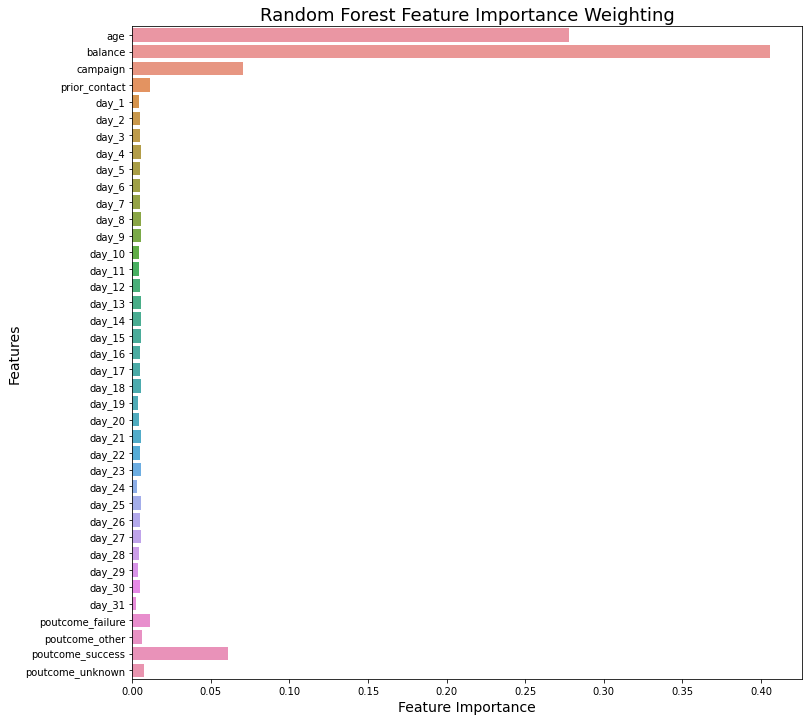

In [11]:
clf = RandomForestClassifier()
# fit the classifier to the training set
clf.fit(X_train, y_train)
# predict on the test set
y_pred = clf.predict(X_test)
acc_ = accuracy_score(y_test, y_pred)
print(acc_)

#for feature in zip(X.columns, clf.feature_importances_.round(3)):
#    print(feature)

plt.figure(figsize=(12,12))
sns.barplot(y=X.columns, x=clf.feature_importances_,orient = 'h');
#plt.xticks(rotation=90);
# visualize feature importance
#with plt.style.context('ggplot', ):
#    sns.set(font_scale=1)
#    plt.figure(num=None, figsize=(14,10), dpi=80, facecolor='w')
plt.title("Random Forest Feature Importance Weighting", size=18)
plt.ylabel('Features', size = 14)
plt.xlabel('Feature Importance', size=14)
#    feat_importances = pd.Series(clf.feature_importances_, index= X.columns)

In [12]:
classifiers = [
    KNeighborsClassifier(3), 
    DecisionTreeClassifier(), 
#     RandomForestClassifier(), 
#     AdaBoostClassifier(), 
#     GradientBoostingClassifier(), 
#     GaussianNB(),
#     BernoulliNB(), 
#     MLPClassifier(), 
#     MLPClassifier(hidden_layer_sizes=[100, 100]),
#     LinearDiscriminantAnalysis(), 
#     LogisticRegression(), 
#     QuadraticDiscriminantAnalysis(), 
]

log_cols=["Classifier", "Accuracy", "F1 Score", "ROC", "Precision", "Recall", "Log Loss", "Sensitivity", "Specificity","True Positives"]
log = pd.DataFrame(columns=log_cols)
    
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("="*60)
    print(name)
    print('****Results****')

    train_predictions = clf.predict(X_test)
    acc_ = accuracy_score(y_test, train_predictions)
    acc = acc_.round(3)
    print("Accuracy: {:.4%}".format(acc))

#     coef_scores = X_scaled
#     coef_scores = clf.coef_
#     print(coef_scores)

    fbeta_ = fbeta_score(y_test, train_predictions, beta=1)
    fbeta = fbeta_.round(3)
    print("F1 Score: {}".format(fbeta))

    roc_ = roc_auc_score(y_test, train_predictions)
    roc = roc_.round(3)
    print("AUC (ROC) Score: {}".format(roc))

    precision_ = precision_score(y_test, train_predictions, average='binary')
    precision = precision_.round(3)
    print("Precision Score: {}".format(precision))

    recall_ = recall_score(y_test, train_predictions)
    recall = recall_.round(3)
    print("Recall Score: {}".format(recall))
    
    TP = confusion_matrix(y_test,train_predictions).ravel()[0]
    FN = confusion_matrix(y_test,train_predictions).ravel()[1]
    sensitivity_ = TP / (TP + FN)
    sensitivity = sensitivity_.round(3)
    print("Sensitivty Score: {}".format(sensitivity))
    
    TN = confusion_matrix(y_test,train_predictions).ravel()[3]
    FP = confusion_matrix(y_test,train_predictions).ravel()[2]
    specificity_ = TN / (TN + FP)
    specificity = specificity_.round(3)
    print("Specificity Score: {}".format(specificity))
    
    true_positives = confusion_matrix(y_test,train_predictions).ravel()[0]
    
    print(f"\nClassic train score: {np.round(clf.score(X_train, y_train),4)}")
    print(f"Classic test score: {np.round(clf.score(X_test, y_test),4)}")
    confusion_matrix_ = confusion_matrix(y_test, train_predictions)
    print(f"Confusion matrix: \n{confusion_matrix_}\n")

    ll_ = log_loss(y_test, train_predictions)
    ll = ll_.round(3)

    log_entry = pd.DataFrame([[name, acc*100, fbeta, roc, precision, recall, ll, sensitivity, specificity, true_positives]], columns=log_cols)
    log = pd.concat([log,log_entry])

# type(coef_scores)
# print(index)
# print(log_entry)
# type(log)

KNeighborsClassifier
****Results****
Accuracy: 86.7000%
F1 Score: 0.927
AUC (ROC) Score: 0.575
Precision Score: 0.9
Recall Score: 0.955
Sensitivty Score: 0.194
Specificity Score: 0.955

Classic train score: 0.9116
Classic test score: 0.867
Confusion matrix: 
[[  305  1268]
 [  536 11455]]

DecisionTreeClassifier
****Results****
Accuracy: 81.5000%
F1 Score: 0.895
AUC (ROC) Score: 0.573
Precision Score: 0.901
Recall Score: 0.888
Sensitivty Score: 0.258
Specificity Score: 0.888

Classic train score: 0.9986
Classic test score: 0.8154
Confusion matrix: 
[[  406  1167]
 [ 1337 10654]]



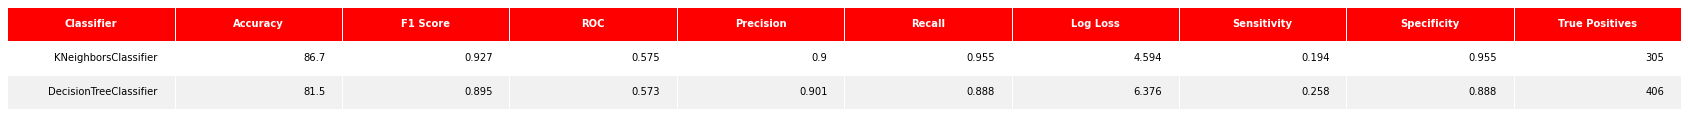

In [13]:
# Save DF as PNG
def render_mpl_table(imputed_df, col_width=6.0, row_height=0.625, font_size=10,
                     header_color='red', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(imputed_df.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=imputed_df.values, bbox=bbox, colLabels=imputed_df.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(log, header_columns=0, col_width=3.0)
fig.savefig("Images/table_mpl_minmax2.png")

<AxesSubplot:ylabel='Classifier'>

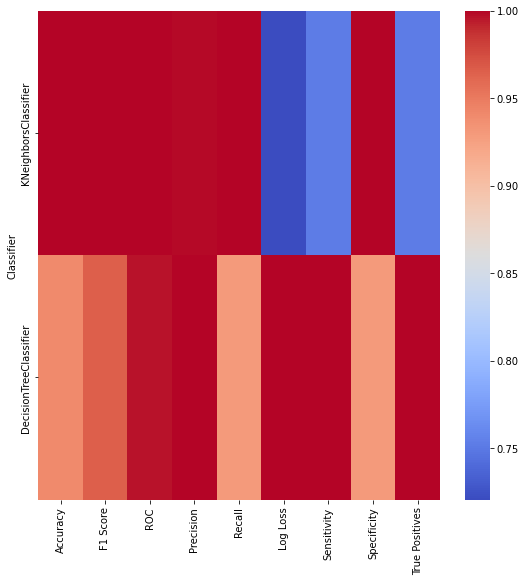

In [14]:
log1 = log.set_index('Classifier')

norm1_df = log1 / log1.max(0)

sns.heatmap(norm1_df.astype('float'),cmap='coolwarm')

### StandardScaler

In [15]:
# StandardScaler, MinMaxScaler, RobustScaler
#scaler = RobustScaler() 
#X_scaled = scaler.fit_transform(imputed_df)

X = imputed_df.drop(columns='deposit')
y = imputed_df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:

classifiers = [
#     MultinomialNB(), # doesn't work
    KNeighborsClassifier(3), # works
#     SVC(kernel="rbf", C=0.001, probability=True), # took a long time... need to refresh memory
#     SVC(kernel='linear'), # took a long time... need to refresh memory
#     NuSVC(probability=True, nu=0.1), # took a long time... need to refresh memory
    DecisionTreeClassifier(), # works
    RandomForestClassifier(), # works
    AdaBoostClassifier(), # works
    GradientBoostingClassifier(), # works
    GaussianNB(), # works
    BernoulliNB(), # works
    MLPClassifier(), # works
    MLPClassifier(hidden_layer_sizes=[100, 100]), # works
    LinearDiscriminantAnalysis(), # works
    LogisticRegression(), # works
    QuadraticDiscriminantAnalysis(), # works
]

log_cols=["Classifier", "Accuracy", "F1 Score", "ROC", "Precision", "Recall", "Log Loss", "Sensitivity", "Specificity", "True Positives"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
#     y_pred = clf.predict(X)
    name = clf.__class__.__name__

    print("="*60)
    print(name)
    print('****Results****')

    train_predictions = clf.predict(X_test)
    acc_ = accuracy_score(y_test, train_predictions)
    acc = acc_.round(3)
    print("Accuracy: {:.4%}".format(acc))

#     coef_scores = X_scaled
#     coef_scores = clf.coef_
#     print(coef_scores)

    fbeta_ = fbeta_score(y_test, train_predictions, beta=1)
    fbeta = fbeta_.round(3)
    print("F1 Score: {}".format(fbeta))

    roc_ = roc_auc_score(y_test, train_predictions)
    roc = roc_.round(3)
    print("AUC (ROC) Score: {}".format(roc))

    precision_ = precision_score(y_test, train_predictions, average='binary')
    precision = precision_.round(3)
    print("Precision Score: {}".format(precision))

    recall_ = recall_score(y_test, train_predictions)
    recall = recall_.round(3)
    print("Recall Score: {}".format(recall))
    
    TP = confusion_matrix(y_test,train_predictions).ravel()[0]
    FN = confusion_matrix(y_test,train_predictions).ravel()[1]
    sensitivity_ = TP / (TP + FN)
    sensitivity = sensitivity_.round(3)
    print("Sensitivty Score: {}".format(sensitivity))
    
    TN = confusion_matrix(y_test,train_predictions).ravel()[3]
    FP = confusion_matrix(y_test,train_predictions).ravel()[2]
    specificity_ = TN / (TN + FP)
    specificity = specificity_.round(3)
    print("Specificity Score: {}".format(specificity))
    
    true_positives = confusion_matrix(y_test,train_predictions).ravel()[0]
    
    print(f"\nClassic train score: {np.round(clf.score(X_train, y_train),4)}")
    print(f"Classic test score: {np.round(clf.score(X_test, y_test),4)}")
    confusion_matrix_ = confusion_matrix(y_test, train_predictions)
    print(f"Confusion matrix: \n{confusion_matrix_}\n")

#     train_predictions = clf.predict_proba(X_test)
    ll_ = log_loss(y_test, train_predictions)
    ll = ll_.round(3)
#     print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc*100, fbeta, roc, precision, recall, ll, sensitivity, specificity, true_positives]], columns=log_cols)
    log = pd.concat([log,log_entry])

# print("="*30)
# type(coef_scores)
# print(index)
# print(log_entry)
# type(log)

KNeighborsClassifier
****Results****
Accuracy: 87.3000%
F1 Score: 0.93
AUC (ROC) Score: 0.586
Precision Score: 0.901
Recall Score: 0.962
Sensitivty Score: 0.211
Specificity Score: 0.962

Classic train score: 0.9096
Classic test score: 0.873
Confusion matrix: 
[[  338  1266]
 [  456 11504]]

DecisionTreeClassifier
****Results****
Accuracy: 82.5000%
F1 Score: 0.9
AUC (ROC) Score: 0.583
Precision Score: 0.901
Recall Score: 0.9
Sensitivty Score: 0.266
Specificity Score: 0.9

Classic train score: 0.9987
Classic test score: 0.8247
Confusion matrix: 
[[  427  1177]
 [ 1201 10759]]

RandomForestClassifier
****Results****
Accuracy: 88.0000%
F1 Score: 0.935
AUC (ROC) Score: 0.583
Precision Score: 0.9
Recall Score: 0.972
Sensitivty Score: 0.193
Specificity Score: 0.972

Classic train score: 0.9986
Classic test score: 0.8803
Confusion matrix: 
[[  310  1294]
 [  330 11630]]

AdaBoostClassifier
****Results****
Accuracy: 89.3000%
F1 Score: 0.942
AUC (ROC) Score: 0.582
Precision Score: 0.899
Recall S

C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier
****Results****
Accuracy: 89.3000%
F1 Score: 0.942
AUC (ROC) Score: 0.596
Precision Score: 0.903
Recall Score: 0.985
Sensitivty Score: 0.207
Specificity Score: 0.985

Classic train score: 0.8963
Classic test score: 0.893
Confusion matrix: 
[[  332  1272]
 [  179 11781]]



C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier
****Results****
Accuracy: 88.0000%
F1 Score: 0.934
AUC (ROC) Score: 0.59
Precision Score: 0.902
Recall Score: 0.97
Sensitivty Score: 0.21
Specificity Score: 0.97

Classic train score: 0.9114
Classic test score: 0.88
Confusion matrix: 
[[  337  1267]
 [  361 11599]]

LinearDiscriminantAnalysis
****Results****
Accuracy: 89.6000%
F1 Score: 0.943
AUC (ROC) Score: 0.597
Precision Score: 0.903
Recall Score: 0.988
Sensitivty Score: 0.206
Specificity Score: 0.988

Classic train score: 0.8914
Classic test score: 0.8955
Confusion matrix: 
[[  330  1274]
 [  143 11817]]

LogisticRegression
****Results****
Accuracy: 89.5000%
F1 Score: 0.943
AUC (ROC) Score: 0.589
Precision Score: 0.901
Recall Score: 0.989
Sensitivty Score: 0.19
Specificity Score: 0.989

Classic train score: 0.8917
Classic test score: 0.8949
Confusion matrix: 
[[  304  1300]
 [  126 11834]]

QuadraticDiscriminantAnalysis
****Results****
Accuracy: 76.6000%
F1 Score: 0.86
AUC (ROC) Score: 0.616
Precision Score: 0.913
Re

C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


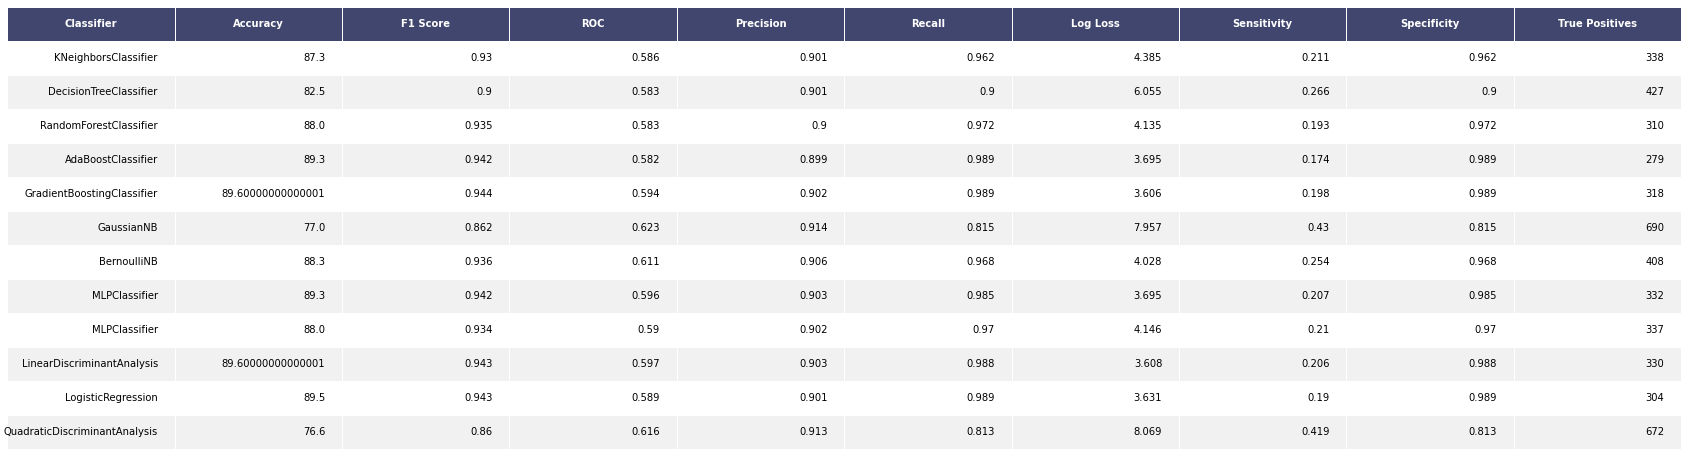

In [17]:
# Save DF as PNG
def render_mpl_table(imputed_df, col_width=6.0, row_height=0.625, font_size=10,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(imputed_df.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=imputed_df.values, bbox=bbox, colLabels=imputed_df.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(log, header_columns=0, col_width=3.0)
fig.savefig("Images/table_mpl_standard2.png")

<AxesSubplot:ylabel='Classifier'>

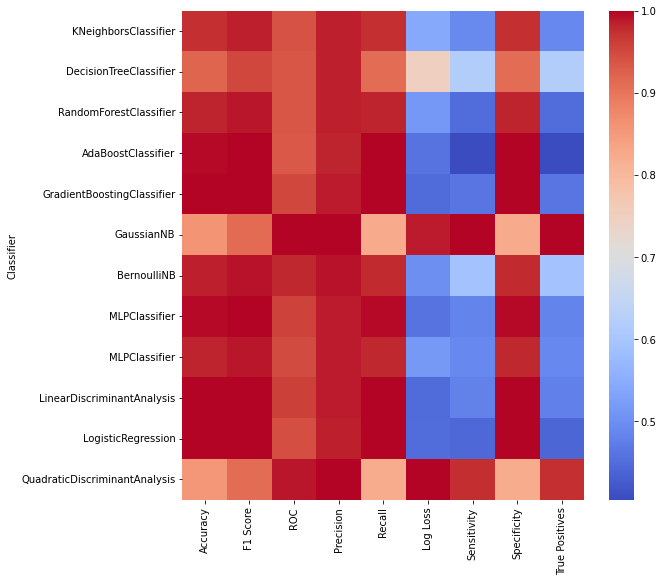

In [18]:
log2 = log.set_index('Classifier')

norm2_df = log2 / log2.max(0)

sns.heatmap(norm2_df.astype('float'),cmap='coolwarm')

### RobustScaler

In [19]:
# StandardScaler, MinMaxScaler, RobustScaler
#scaler = RobustScaler() 
#X_scaled = scaler.fit_transform(imputed_df)

X = imputed_df.drop(columns='deposit')
y = imputed_df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

scaler = RobustScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:

classifiers = [
#     MultinomialNB(), # doesn't work
    KNeighborsClassifier(3), # works
#     SVC(kernel="rbf", C=0.001, probability=True), # took a long time... need to refresh memory
#     SVC(kernel='linear'), # took a long time... need to refresh memory
#     NuSVC(probability=True, nu=0.1), # took a long time... need to refresh memory
    DecisionTreeClassifier(), # works
    RandomForestClassifier(), # works
    AdaBoostClassifier(), # works
    GradientBoostingClassifier(), # works
    GaussianNB(), # works
    BernoulliNB(), # works
    MLPClassifier(), # works
    MLPClassifier(hidden_layer_sizes=[100, 100]), # works
    LinearDiscriminantAnalysis(), # works
    LogisticRegression(), # works
    QuadraticDiscriminantAnalysis(), # works
]

log_cols=["Classifier", "Accuracy", "F1 Score", "ROC", "Precision", "Recall", "Log Loss", "Sensitivity", "Specificity", "True Positives"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
#     y_pred = clf.predict(X)
    name = clf.__class__.__name__

    print("="*60)
    print(name)
    print('****Results****')

    train_predictions = clf.predict(X_test)
    acc_ = accuracy_score(y_test, train_predictions)
    acc = acc_.round(3)
    print("Accuracy: {:.4%}".format(acc))

#     coef_scores = X_scaled
#     coef_scores = clf.coef_
#     print(coef_scores)

    fbeta_ = fbeta_score(y_test, train_predictions, beta=1)
    fbeta = fbeta_.round(3)
    print("F1 Score: {}".format(fbeta))

    roc_ = roc_auc_score(y_test, train_predictions)
    roc = roc_.round(3)
    print("AUC (ROC) Score: {}".format(roc))

    precision_ = precision_score(y_test, train_predictions, average='binary')
    precision = precision_.round(3)
    print("Precision Score: {}".format(precision))

    recall_ = recall_score(y_test, train_predictions)
    recall = recall_.round(3)
    print("Recall Score: {}".format(recall))
    
    TP = confusion_matrix(y_test,train_predictions).ravel()[0]
    FN = confusion_matrix(y_test,train_predictions).ravel()[1]
    sensitivity_ = TP / (TP + FN)
    sensitivity = sensitivity_.round(3)
    print("Sensitivty Score: {}".format(sensitivity))
    
    TN = confusion_matrix(y_test,train_predictions).ravel()[3]
    FP = confusion_matrix(y_test,train_predictions).ravel()[2]
    specificity_ = TN / (TN + FP)
    specificity = specificity_.round(3)
    print("Specificity Score: {}".format(specificity))
    
    true_positives = confusion_matrix(y_test,train_predictions).ravel()[0]
    
    print(f"\nClassic train score: {np.round(clf.score(X_train, y_train),4)}")
    print(f"Classic test score: {np.round(clf.score(X_test, y_test),4)}")
    confusion_matrix_ = confusion_matrix(y_test, train_predictions)
    print(f"Confusion matrix: \n{confusion_matrix_}\n")

#     train_predictions = clf.predict_proba(X_test)
    ll_ = log_loss(y_test, train_predictions)
    ll = ll_.round(3)
#     print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc*100, fbeta, roc, precision, recall, ll, sensitivity, specificity, true_positives]], columns=log_cols)
    log = pd.concat([log,log_entry])

# print("="*30)
# type(coef_scores)
# print(index)
# print(log_entry)
# type(log)

KNeighborsClassifier
****Results****
Accuracy: 87.0000%
F1 Score: 0.929
AUC (ROC) Score: 0.568
Precision Score: 0.9
Recall Score: 0.96
Sensitivty Score: 0.177
Specificity Score: 0.96

Classic train score: 0.9107
Classic test score: 0.8699
Confusion matrix: 
[[  276  1287]
 [  478 11523]]

DecisionTreeClassifier
****Results****
Accuracy: 81.8000%
F1 Score: 0.897
AUC (ROC) Score: 0.57
Precision Score: 0.901
Recall Score: 0.893
Sensitivty Score: 0.248
Specificity Score: 0.893

Classic train score: 0.9987
Classic test score: 0.8185
Confusion matrix: 
[[  387  1176]
 [ 1286 10715]]

RandomForestClassifier
****Results****
Accuracy: 87.8000%
F1 Score: 0.933
AUC (ROC) Score: 0.576
Precision Score: 0.901
Recall Score: 0.968
Sensitivty Score: 0.184
Specificity Score: 0.968

Classic train score: 0.9986
Classic test score: 0.8775
Confusion matrix: 
[[  288  1275]
 [  386 11615]]

AdaBoostClassifier
****Results****
Accuracy: 89.3000%
F1 Score: 0.942
AUC (ROC) Score: 0.578
Precision Score: 0.901
Rec

C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier
****Results****
Accuracy: 88.9000%
F1 Score: 0.94
AUC (ROC) Score: 0.589
Precision Score: 0.904
Recall Score: 0.979
Sensitivty Score: 0.198
Specificity Score: 0.979

Classic train score: 0.8981
Classic test score: 0.8893
Confusion matrix: 
[[  310  1253]
 [  249 11752]]



C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier
****Results****
Accuracy: 86.9000%
F1 Score: 0.928
AUC (ROC) Score: 0.58
Precision Score: 0.902
Recall Score: 0.956
Sensitivty Score: 0.204
Specificity Score: 0.956

Classic train score: 0.9171
Classic test score: 0.8691
Confusion matrix: 
[[  319  1244]
 [  532 11469]]

LinearDiscriminantAnalysis
****Results****
Accuracy: 89.5000%
F1 Score: 0.943
AUC (ROC) Score: 0.589
Precision Score: 0.904
Recall Score: 0.986
Sensitivty Score: 0.192
Specificity Score: 0.986

Classic train score: 0.8919
Classic test score: 0.8946
Confusion matrix: 
[[  300  1263]
 [  167 11834]]

LogisticRegression
****Results****
Accuracy: 89.5000%
F1 Score: 0.943
AUC (ROC) Score: 0.587
Precision Score: 0.903
Recall Score: 0.987
Sensitivty Score: 0.186
Specificity Score: 0.987

Classic train score: 0.8917
Classic test score: 0.8946
Confusion matrix: 
[[  291  1272]
 [  157 11844]]

QuadraticDiscriminantAnalysis
****Results****
Accuracy: 71.5000%
F1 Score: 0.822
AUC (ROC) Score: 0.615
Precision Score: 0

C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


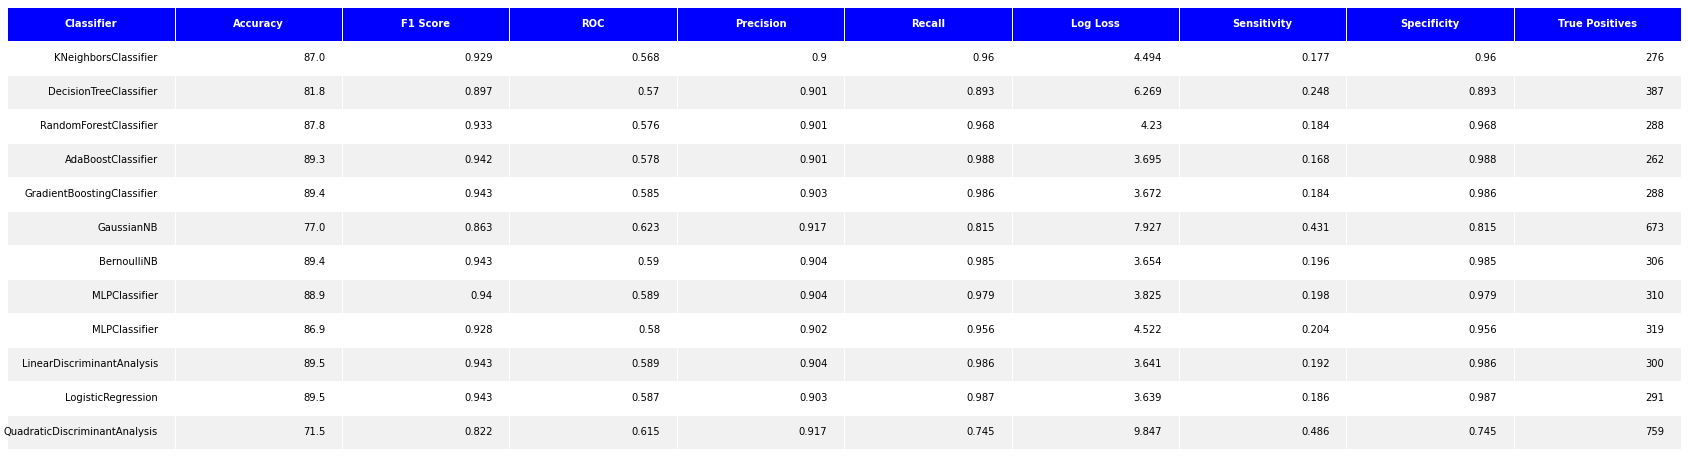

In [21]:
# Save DF as PNG
def render_mpl_table(imputed_df, col_width=6.0, row_height=0.625, font_size=10,
                     header_color='blue', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(imputed_df.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=imputed_df.values, bbox=bbox, colLabels=imputed_df.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(log, header_columns=0, col_width=3.0)
fig.savefig("Images/table_mpl_robust2.png")

<AxesSubplot:ylabel='Classifier'>

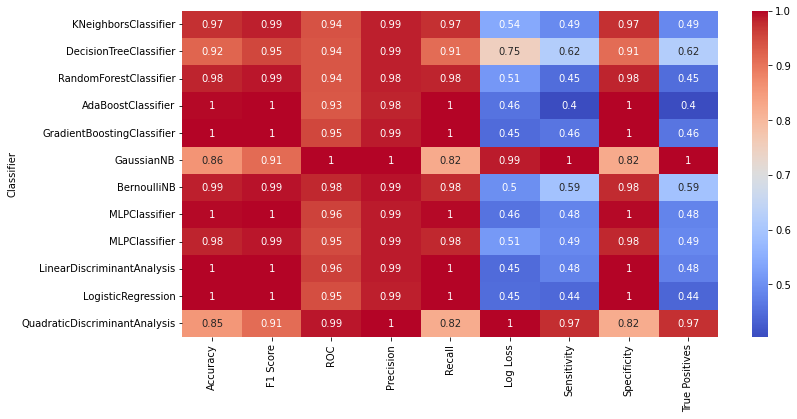

In [22]:
log3 = log.set_index('Classifier')

norm3_df = log3 / log3.max(0)

plt.figure(figsize=(12,6))
sns.heatmap(norm2_df.astype('float'),cmap='coolwarm',annot=True)

<AxesSubplot:ylabel='Classifier'>

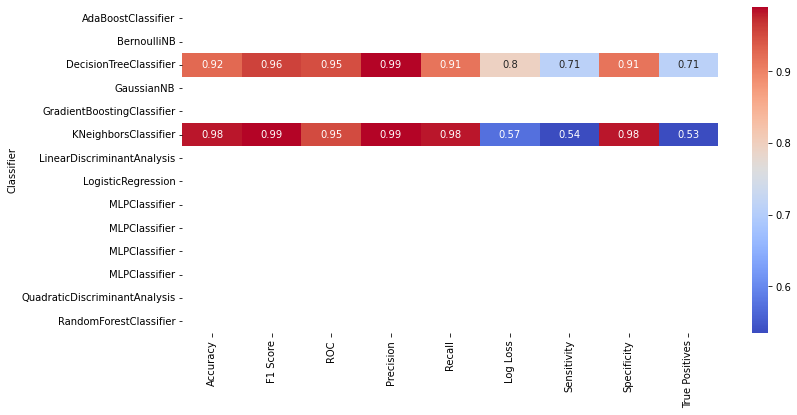

In [23]:
big_norm_df = (norm1_df + norm2_df + norm3_df) / 3

plt.figure(figsize=(12,6))
sns.heatmap(big_norm_df.astype('float'),cmap='coolwarm',annot=True)

In [24]:
big_log_df = (log1 + log2 + log3) / 3

big_log_df

,Accuracy,F1 Score,ROC,Precision,Recall,Log Loss,Sensitivity,Specificity,True Positives
Classifier,,,,,,,,,
AdaBoostClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BernoulliNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DecisionTreeClassifier,81.933333,0.897333,0.575333,0.901,0.893667,6.233333,0.257333,0.893667,406.666667
GaussianNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GradientBoostingClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KNeighborsClassifier,87.0,0.928667,0.576333,0.900333,0.959,4.491,0.194,0.959,306.333333
LinearDiscriminantAnalysis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLPClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#plt.figure(figsize=(24,3))
#sns.barplot(X.columns,logreg.coef_[0])
#plt.xticks(rotation=60)
#plt.title("Extracting the Feature Importance");

### Further discussion for the group
* **What further refinements to the dataset should we make as part of the EDA / cleanup?**
    * Removing the *pdays* variable, for example
    * Dropping outliers 
* **How might the use of other classification algorithms and scalers affect the final predictions?**
    * ~Algorithms like LogisticRegression, DecisionTree, RandomForest, Kneighbors, NaiveBayes, neural net, etc.~
    * Scalers like StandardScaler, MinMaxScaler, RobustScaler
    * PCA (principal component analysis) to reduce dimensions
* **Playing with parameters, pipelines, gridsearches to maximize True Negatives and minimize False Negatives**
    * That is, maximize deposit==1 correct predictions and reducing deposit==0 wrong predictions
    * Even if that means accidentally overpredicting the number of true deposits, better to try a bad path than miss a potential business opportunity
* **Extending this to other predictions**
    * e.g. predicting the "default" variable, or some other classification
    * e.g. predicting a range for continuous values based on categorical values
* **Best ways to impute missing data?**
    * 